In [1]:
library(tidyverse)
library(mice)
library(VIM)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep




In [2]:
GIT_ROOT <- system2("git", args = c("rev-parse", "--show-toplevel"), stdout=TRUE)
INGEST <- file.path(GIT_ROOT, "build/ingest")
UTIL <- file.path(GIT_ROOT, "src/util.R") 

In [3]:
# Construct and return a dataframe from the given dataset where 
# the heart disease class is grouped by the target attribute with
# classes given as a vector. The columns in the dataframe will be
# 'heart_disease_class', the name of the grouping attribute, and 
# 'fraction', which is the fraction of the attribute that belongs
# to the heart disease class given by the first column.
group_by_attribute <- function(dataset, attribute, classes) {
    class_totals <- list()
    for(i in 1:length(classes)) class_totals[i] <- sum(dataset[[attribute]] == classes[i], na.rm=TRUE)
    fractions <- list()
    categories <- list()
    categories_by_attribute <- data.frame()
    for(heart_disease_class in 0:4) {
        for(i in 1:length(classes)) {
            attribute_class <- classes[i]
            samples_per_class <- dataset[dataset$target == heart_disease_class,][[attribute]] == attribute_class
            sample_count <- sum(samples_per_class, na.rm=TRUE)
            class_total <- class_totals[[i]]
            fraction <- sample_count / class_total
            categories_by_attribute <- rbind(categories_by_attribute, 
                                             c(heart_disease_class, attribute_class, fraction))       
        }
    }
    colnames(categories_by_attribute) <- c('heart_disease_class', attribute, 'fraction')
    return(categories_by_attribute)
}

In [4]:
source(UTIL)
uci_dataset <- read_dir(INGEST, 
                        columns = c('age', 'sex', 'cp', 'trestbps', 'fbs', 'restecg', 
                                    'thalach', 'exang', 'oldpeak', 'target'))
summary(uci_dataset$df)

      age             sex               cp          trestbps    
 Min.   :28.00   Min.   :0.0000   Min.   :1.00   Min.   :  0.0  
 1st Qu.:47.00   1st Qu.:1.0000   1st Qu.:3.00   1st Qu.:120.0  
 Median :54.00   Median :1.0000   Median :4.00   Median :130.0  
 Mean   :53.51   Mean   :0.7891   Mean   :3.25   Mean   :132.1  
 3rd Qu.:60.00   3rd Qu.:1.0000   3rd Qu.:4.00   3rd Qu.:140.0  
 Max.   :77.00   Max.   :1.0000   Max.   :4.00   Max.   :200.0  
                                                 NA's   :59     
      fbs            restecg          thalach          exang       
 Min.   :0.0000   Min.   :0.0000   Min.   : 60.0   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:120.0   1st Qu.:0.0000  
 Median :0.0000   Median :0.0000   Median :140.0   Median :0.0000  
 Mean   :0.1663   Mean   :0.6046   Mean   :137.5   Mean   :0.3896  
 3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.:157.0   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :2.0000   Max.   :202.0   Max.   :1.0000  
 NA'

In [5]:
uci_dataset$df <- uci_dataset$df[uci_dataset$df$trestbps != 0,]

,age,sex,cp,trestbps,thalach,exang,target,restecg,oldpeak,fbs,
766,1,1,1,1,1,1,1,1,1,1,0
85,1,1,1,1,1,1,1,1,1,0,1
4,1,1,1,1,1,1,1,1,0,1,1
3,1,1,1,1,1,1,1,1,0,0,2
1,1,1,1,1,1,1,1,0,1,1,1
1,1,1,1,1,1,1,1,0,1,0,2
59,0,0,0,0,0,0,0,0,0,0,10
,59,59,59,59,59,59,59,61,66,148,688


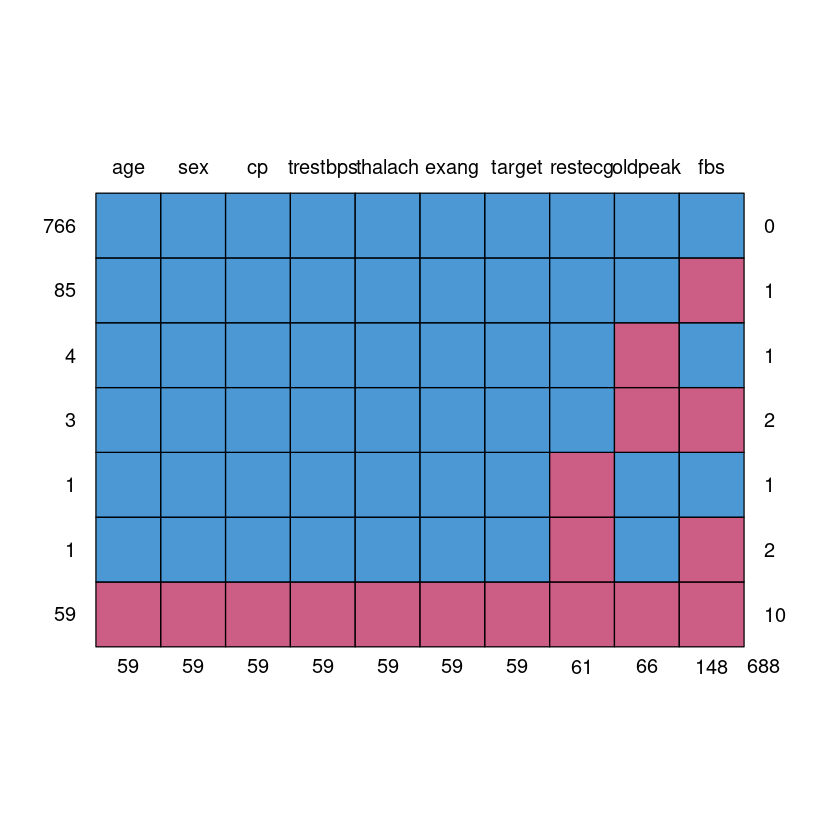

In [6]:
md.pattern(uci_dataset$df)

In [7]:
md.pairs(uci_dataset$df)

,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,target
age,860,860,860,860,771,858,860,860,853,860
sex,860,860,860,860,771,858,860,860,853,860
cp,860,860,860,860,771,858,860,860,853,860
trestbps,860,860,860,860,771,858,860,860,853,860
fbs,771,771,771,771,771,770,771,771,767,771
restecg,858,858,858,858,770,858,858,858,851,858
thalach,860,860,860,860,771,858,860,860,853,860
exang,860,860,860,860,771,858,860,860,853,860
oldpeak,853,853,853,853,767,851,853,853,853,853
target,860,860,860,860,771,858,860,860,853,860


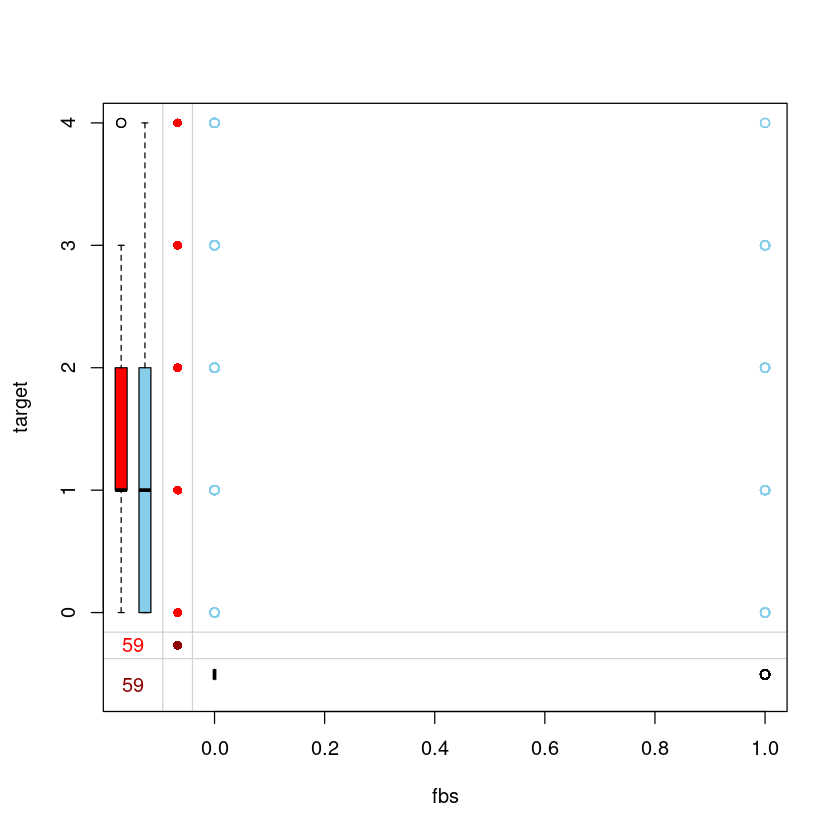

In [8]:
marginplot(uci_dataset$df[, c("fbs", "target")])

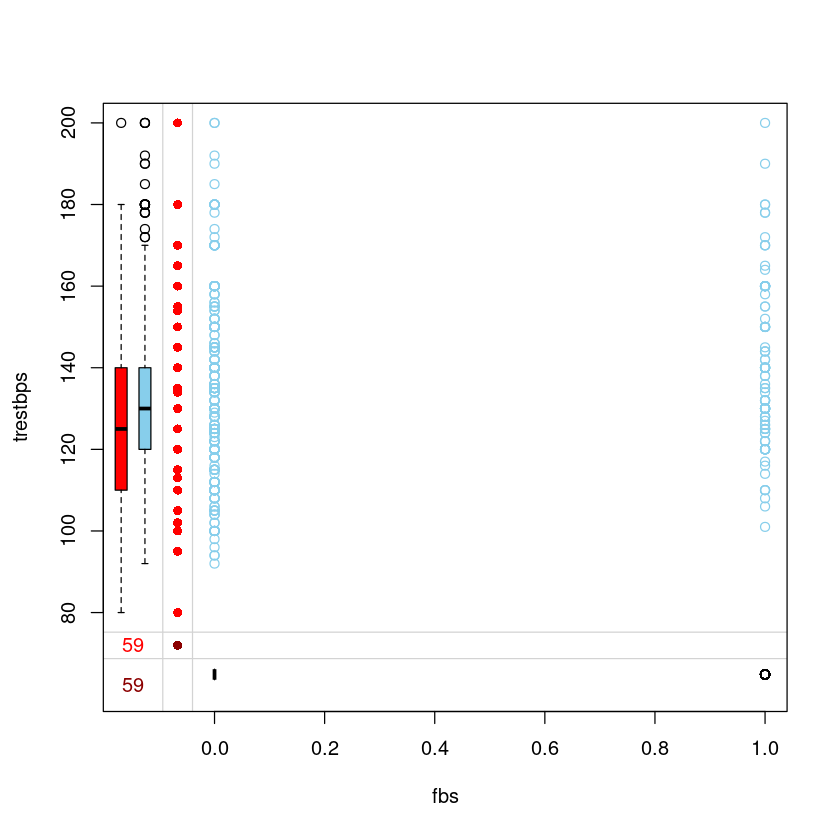

In [9]:
marginplot(uci_dataset$df[, c("fbs", "trestbps")])

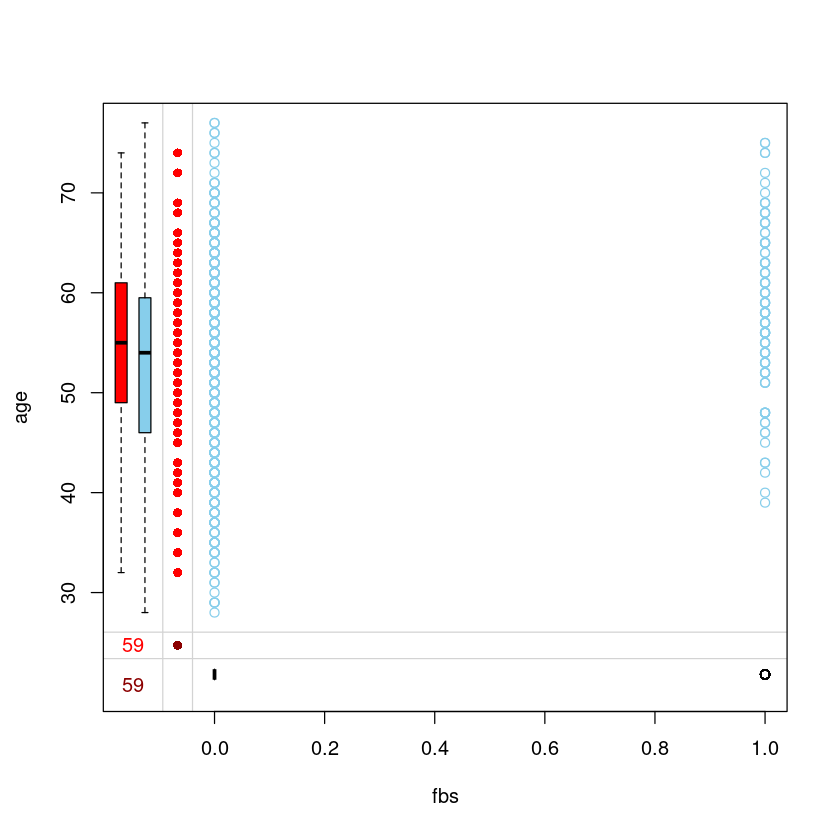

In [10]:
marginplot(uci_dataset$df[, c("fbs", "age")])

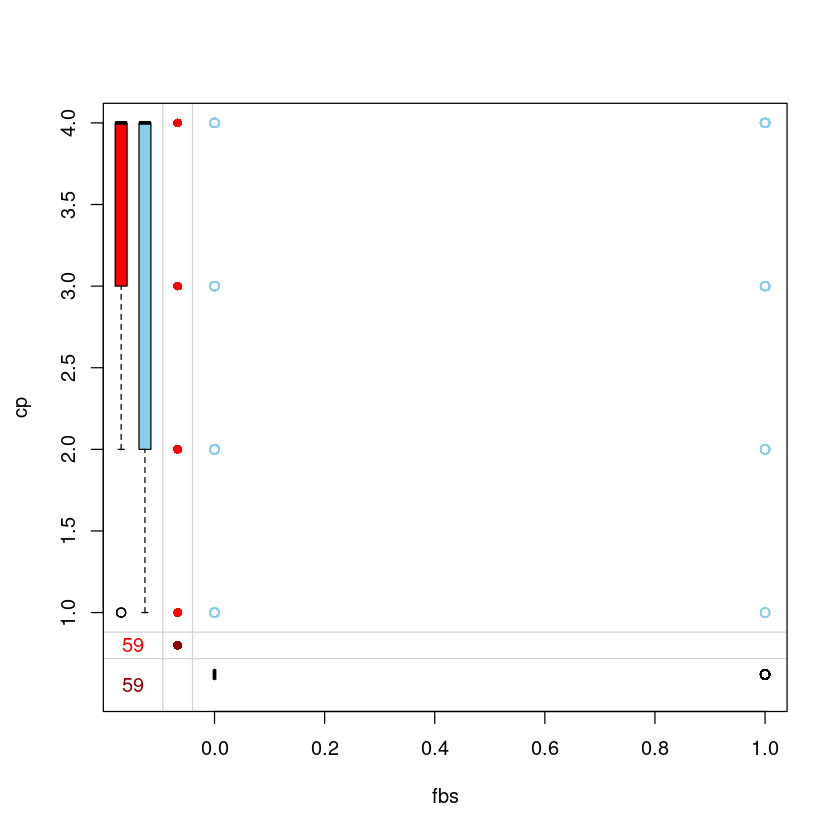

In [11]:
marginplot(uci_dataset$df[, c("fbs", "cp")])

,age,sex,cp,trestbps,thalach,exang,target,restecg,oldpeak,fbs,
766,1,1,1,1,1,1,1,1,1,1,0
85,1,1,1,1,1,1,1,1,1,0,1
4,1,1,1,1,1,1,1,1,0,1,1
1,1,1,1,1,1,1,1,0,1,1,1
,0,0,0,0,0,0,0,1,4,85,90


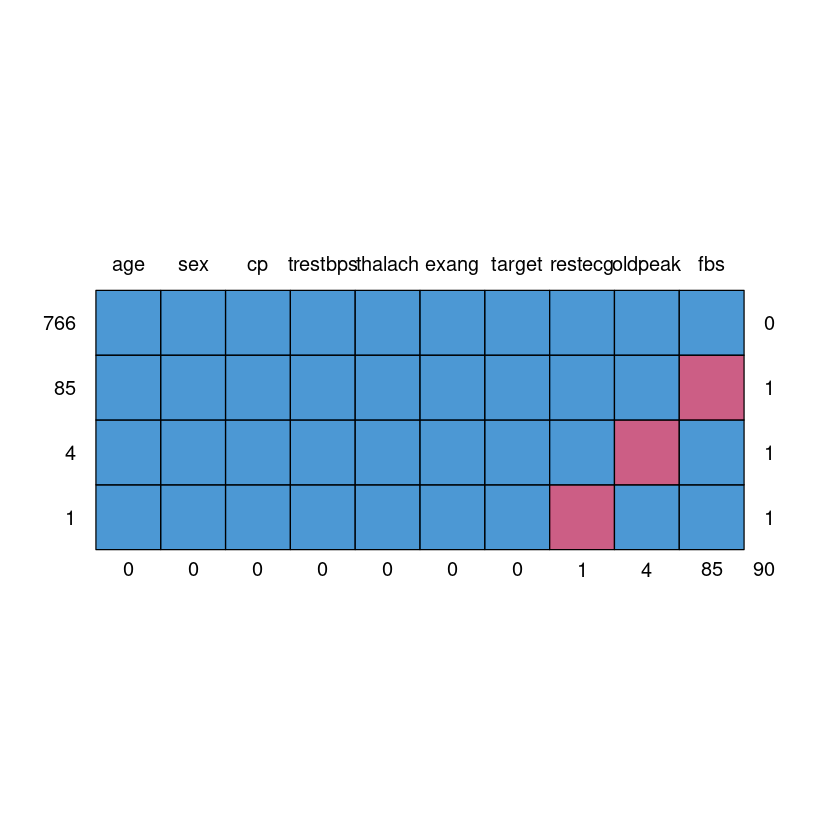

In [12]:
uci_dataset$df <- uci_dataset$df[rowSums(is.na(uci_dataset$df))<2,]
md.pattern(uci_dataset$df)

In [13]:
uci_dataset$df$restecg <- as.factor(uci_dataset$df$restecg)
uci_dataset$df$fbs <- as.factor(uci_dataset$df$fbs)

In [14]:
imp <- mice(uci_dataset$df, 
            seed = 1467756838, 
            method = c("", "", "", "", "logreg", "polyreg", "", "", "pmm", ""),
            visit = "monotone",
            maxit = 20,
            m = 5)


 iter imp variable
  1   1  restecg  oldpeak  fbs
  1   2  restecg  oldpeak  fbs
  1   3  restecg  oldpeak  fbs
  1   4  restecg  oldpeak  fbs
  1   5  restecg  oldpeak  fbs
  2   1  restecg  oldpeak  fbs
  2   2  restecg  oldpeak  fbs
  2   3  restecg  oldpeak  fbs
  2   4  restecg  oldpeak  fbs
  2   5  restecg  oldpeak  fbs
  3   1  restecg  oldpeak  fbs
  3   2  restecg  oldpeak  fbs
  3   3  restecg  oldpeak  fbs
  3   4  restecg  oldpeak  fbs
  3   5  restecg  oldpeak  fbs
  4   1  restecg  oldpeak  fbs
  4   2  restecg  oldpeak  fbs
  4   3  restecg  oldpeak  fbs
  4   4  restecg  oldpeak  fbs
  4   5  restecg  oldpeak  fbs
  5   1  restecg  oldpeak  fbs
  5   2  restecg  oldpeak  fbs
  5   3  restecg  oldpeak  fbs
  5   4  restecg  oldpeak  fbs
  5   5  restecg  oldpeak  fbs
  6   1  restecg  oldpeak  fbs
  6   2  restecg  oldpeak  fbs
  6   3  restecg  oldpeak  fbs
  6   4  restecg  oldpeak  fbs
  6   5  restecg  oldpeak  fbs
  7   1  restecg  oldpeak  fbs
  7   2  restecg  o

In [15]:
imputed_dataset <- complete(imp, 1)
imp

Class: mids
Number of multiple imputations:  5 
Imputation methods:
      age       sex        cp  trestbps       fbs   restecg   thalach     exang 
       ""        ""        ""        ""  "logreg" "polyreg"        ""        "" 
  oldpeak    target 
    "pmm"        "" 
PredictorMatrix:
         age sex cp trestbps fbs restecg thalach exang oldpeak target
age        0   1  1        1   1       1       1     1       1      1
sex        1   0  1        1   1       1       1     1       1      1
cp         1   1  0        1   1       1       1     1       1      1
trestbps   1   1  1        0   1       1       1     1       1      1
fbs        1   1  1        1   0       1       1     1       1      1
restecg    1   1  1        1   1       0       1     1       1      1

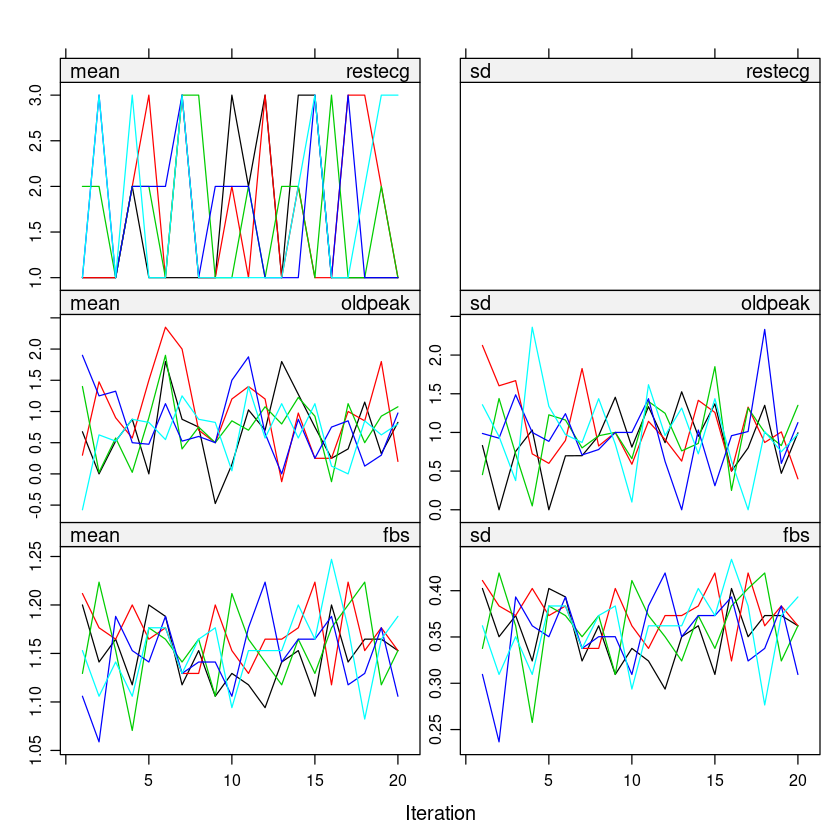

In [16]:
plot(imp, c("restecg", "oldpeak", "fbs"))

In [17]:
imputed_fbs <- as.numeric(imputed_dataset[is.na(uci_dataset$df$fbs),]$fbs)
summary(imputed_fbs)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.153   1.000   2.000 

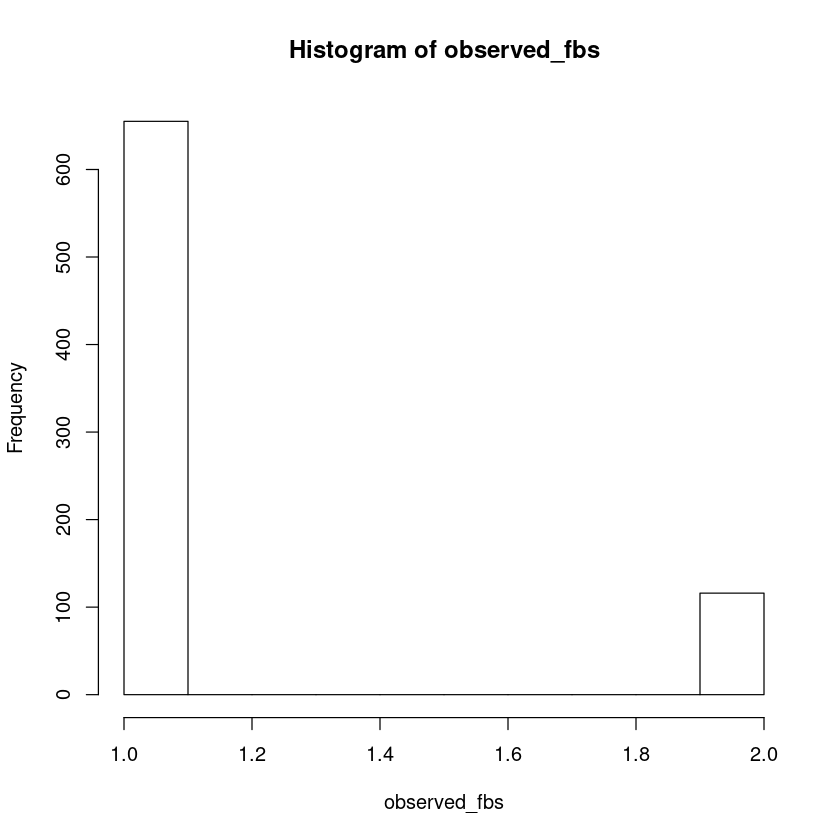

In [18]:
observed_fbs <- as.numeric(uci_dataset$df[!is.na(uci_dataset$df$fbs),]$fbs)
hist(observed_fbs)

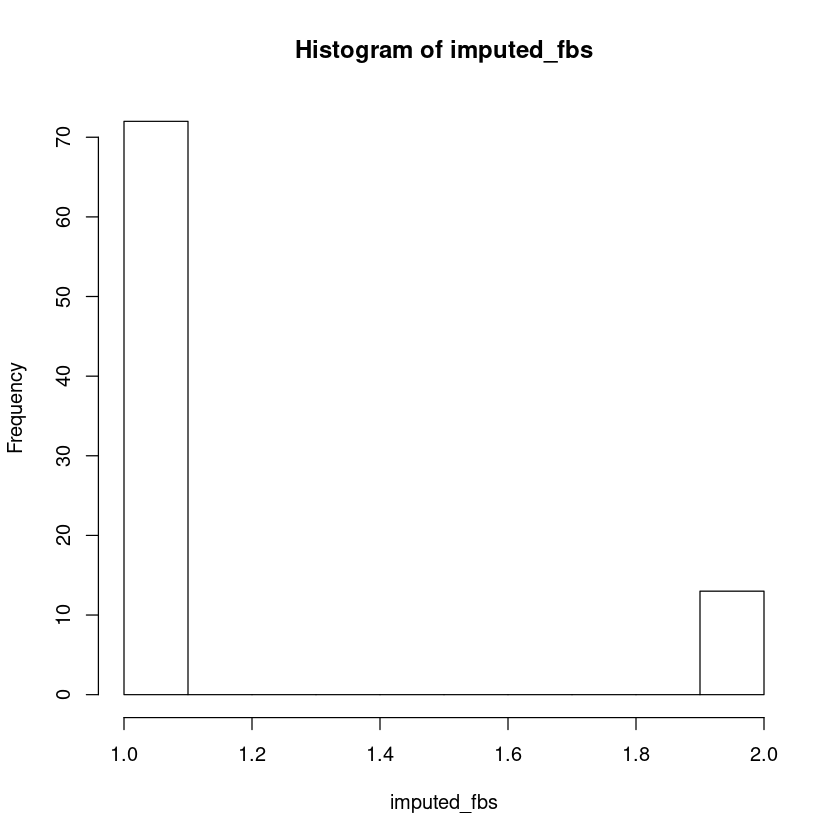

In [19]:
hist(imputed_fbs)

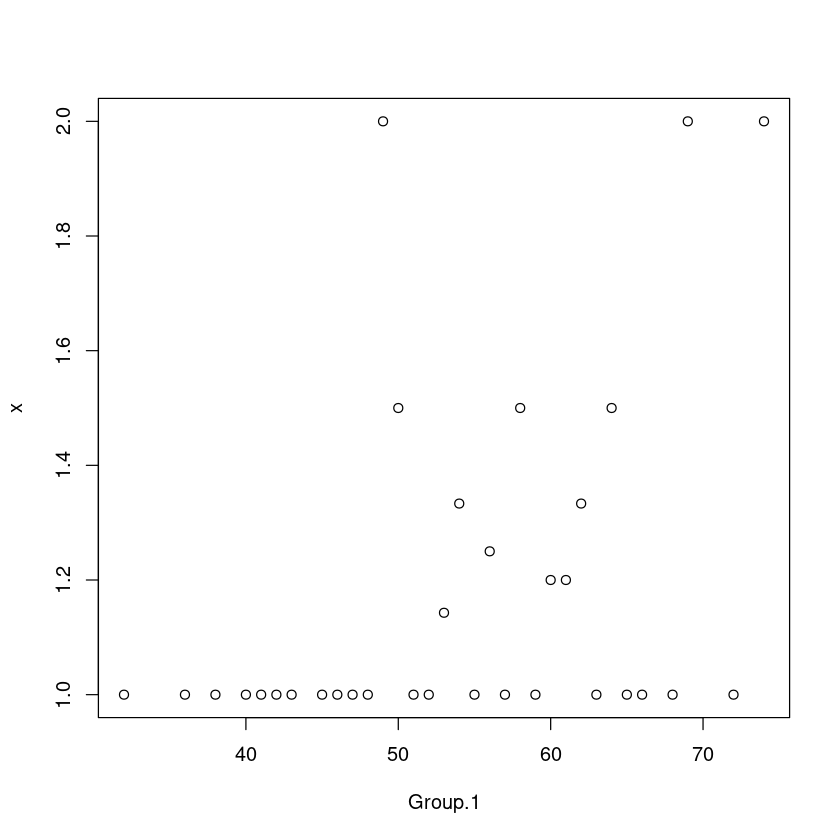

In [20]:
age_missing_fbs <- uci_dataset$df[is.na(uci_dataset$df$fbs),]$age
mean_imputed_fbs <- aggregate(imputed_fbs, list(age_missing_fbs), mean)
plot(mean_imputed_fbs)

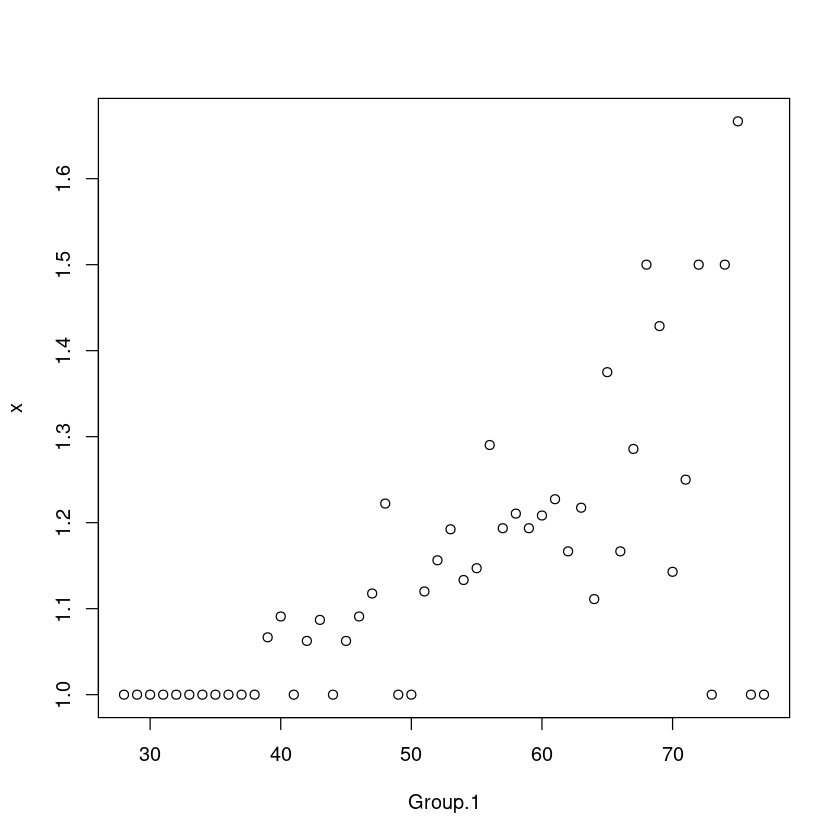

In [21]:
age_with_fbs <- uci_dataset$df[!is.na(uci_dataset$df$fbs),]$age
mean_observed_fbs <- aggregate(observed_fbs, list(age_with_fbs), mean)
plot(mean_observed_fbs)

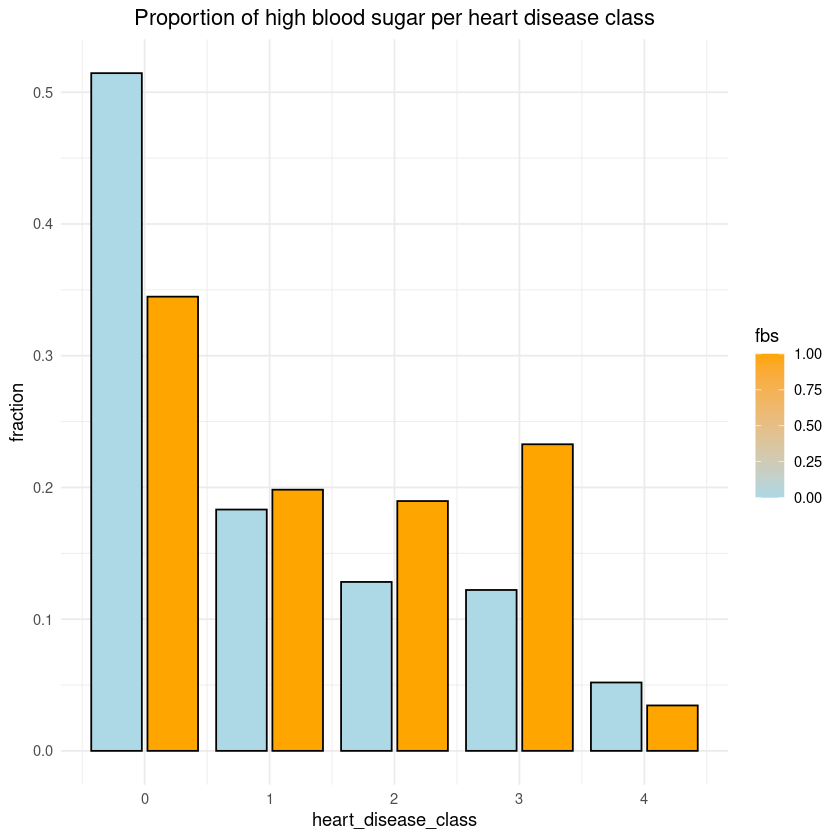

In [22]:
# Bar graph of heart disease categories grouped by observed fasting blood sugar.
categories_by_fbs <- group_by_attribute(uci_dataset$df, 'fbs', c(0, 1))
ggplot(categories_by_fbs, aes(fill=fbs, y=fraction, x=heart_disease_class)) + ggtitle(label='Proportion of high blood sugar per heart disease class') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='lightblue', high='orange') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

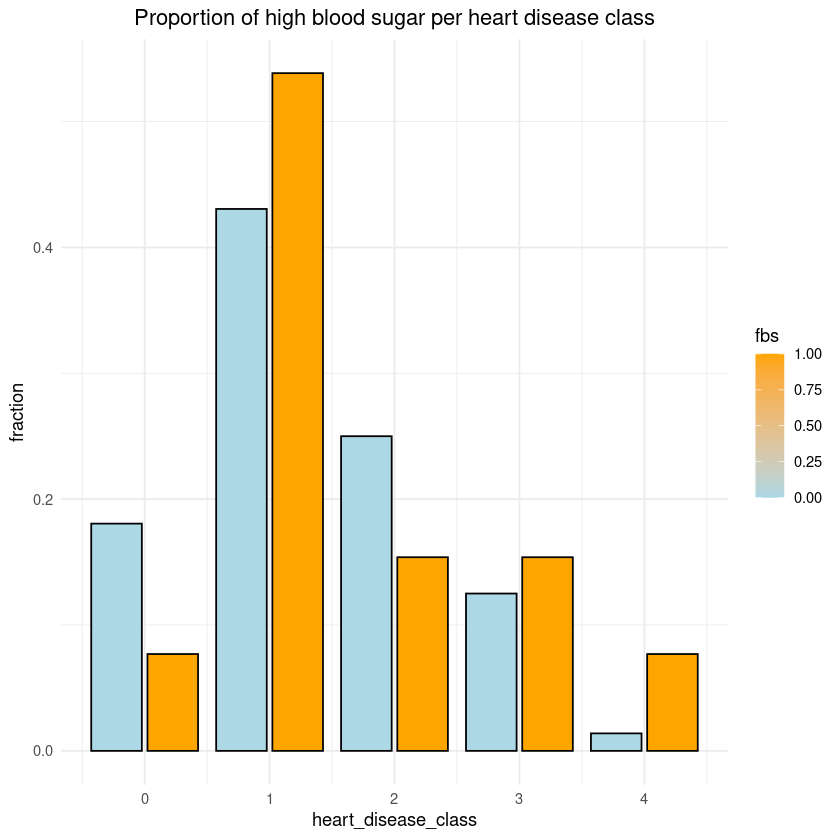

In [23]:
# Bar graph of heart disease categories grouped by imputed fasting blood sugar.
imputed_fbs_dataset <- imputed_dataset[is.na(uci_dataset$df$fbs),]
categories_by_imputed_fbs <- group_by_attribute(imputed_fbs_dataset, 'fbs', c(0, 1))
ggplot(categories_by_imputed_fbs, aes(fill=fbs, y=fraction, x=heart_disease_class)) + ggtitle(label='Proportion of high blood sugar per heart disease class') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='lightblue', high='orange') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [24]:
imputed_restecg <- imputed_dataset[is.na(uci_dataset$df$restecg),]
imputed_restecg

,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,target
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
542,55,1,1,140,0,0,136,0,0,3


In [25]:
imputed_oldpeak <- imputed_dataset[is.na(uci_dataset$df$oldpeak),]
imputed_oldpeak

,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,target
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
668,55,1,2,110,1,1,180,0,0.0,0
695,62,1,1,112,0,1,150,1,2.0,1
736,53,1,3,155,1,1,160,0,0.0,0
882,65,1,4,160,1,1,122,0,1.3,3
